In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import string
import cv2
from concurrent.futures import ProcessPoolExecutor

The Plate is 16 columns and 24 rows

In [3]:
DATA_DIR = '/data/'
RECURSION_DIR = os.path.join(DATA_DIR, 'recursion')
RECURSION_TRAIN = os.path.join(RECURSION_DIR, 'train')
RECURSION_TEST = os.path.join(RECURSION_DIR, 'test')
CELL_TYPES = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']
PLATES = ['Plate1', 'Plate2', 'Plate3', 'Plate4']
LETTER_TO_IX = {}
for ix, letter in enumerate(string.ascii_uppercase[:16]):
    LETTER_TO_IX[letter] = ix 
IX_TO_LETTER = {v: k for k, v in LETTER_TO_IX.items()}

def parse_filename(s, full_path=False):
    ''' Returns row, col, site, channel of a string in the format of the kaggle filename. '''
    #first _ is always 3rd index
    if full_path:
        s = s[-13:]
    col = LETTER_TO_IX[s[0]]
    row = int(s[1:3]) - 1
    site = int(s[5:6]) - 1
    channel = int(s[8:9]) - 1
    return row, col, site, channel  

def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0
    return img

def read_parse_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0
    info = parse_filename(path, True)
    return img, info

In [6]:
class Plate:
    def __init__(self, cell_type, plate_num):
        self.images = np.zeros((24, 16, 2, 6, 512, 512), dtype=np.float32) - 1
        self.labels = np.zeros((24, 16), dtype=np.int32) - 1 
        self.cell_type = cell_type
        self.plate_num = plate_num
        
    def load_images(self, files):
        indices = []
        images = []
        for path in files:
            img = read_image(path)
            ix = parse_filename(path, True)
            indices.append(ix)
            images.append(img)
        images = np.array(images)
        indices = np.array(indices)
        self.images[indices[:, 0], indices[:, 1], indices[:, 2], indices[:, 3]] = images
        
    def get_image(self, s):
        ix = parse_filename(s)
        return self.images[ix]
    
    
    def load_labels(self):
        pass
        
    def __repr__(self):
        return f'<Plate: plate_num: {self.plate_num}, cell_type: {self.cell_type}>'

class Experiment: 
    def __init__(self, cell_type, exp_num, split):
        self.cell_type = cell_type
        self.exp_num = exp_num
        self.split = split 
        self.plates = []
        
    def load_plates(self):
        exp_dir = os.path.join(RECURSION_DIR, self.split, '{}-{:02d}'.format(self.cell_type, self.exp_num))
        for i, p in enumerate(PLATES):
            plate = Plate(self.cell_type, i+1)
            plate_dir = os.path.join(exp_dir, p)
            plate_files = os.listdir(plate_dir)
            plate_files = [os.path.join(plate_dir, f) for f in plate_files]
            plate.load_images(plate_files)
            self.plates.append(plate)
        
    def __repr__(self):
        return f'<Experiment: cell_type: {self.cell_type}, exp_num: {self.exp_num}, split: {self.split} >'

In [7]:
#HEPG2-08 and HEPG2-11

In [8]:
%%time
exp1 = Experiment('HEPG2', 8, 'train')
exp1.load_plates()

CPU times: user 1min 8s, sys: 1min 31s, total: 2min 39s
Wall time: 1min 18s


In [9]:
%%time
exp2 = Experiment('HEPG2', 11, 'train')
exp2.load_plates()

CPU times: user 1min 10s, sys: 1min 32s, total: 2min 43s
Wall time: 5min 27s


In [10]:
files = os.listdir(os.path.join(RECURSION_TRAIN, 'HUVEC-22', PLATES[3]))
files = [os.path.join(RECURSION_TRAIN, 'HUVEC-22', PLATES[3], i) for i in files]

In [12]:
%%time
with ProcessPoolExecutor(max_workers=12) as executor:
    images = list(executor.map(read_parse_image, files))

OSError: [Errno 12] Cannot allocate memory

In [48]:
%%time
indices = []
images = []
for path in files:
    img = read_image(path)
    ix = parse_filename(path, True)
    indices.append(ix)
    images.append(img)
images = np.array(images)
indices = np.array(indices)

CPU times: user 12.4 s, sys: 2.47 s, total: 14.8 s
Wall time: 14.8 s


In [14]:
plate = np.zeros((24, 16, 2, 6, 512, 512), dtype=np.float32) - 1 

In [21]:
plate[indices[:, 0], indices[:, 1], indices[:, 2], indices[:, 3]] = images

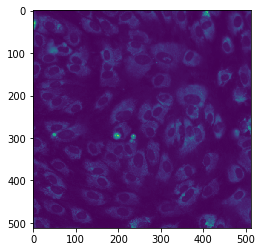

In [32]:
plt.imshow(images[100])

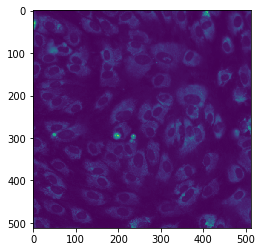

In [33]:
plt.imshow(plate[tuple(indices[100])])

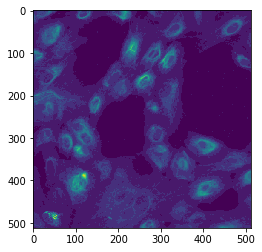

In [280]:
plt.imshow(images[0])

In [332]:
a = np.zeros((3, 3, 2, 2))

In [335]:
indices.shape

(3696, 4)

In [330]:
np.put(a, (0, 0), [1, 1, 1, 1])

In [331]:
a[0, 0]

array([[1., 0.],
       [0., 0.]])

In [319]:
plate[tuple(indices[0])]

array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)

In [317]:
plate[indices] = images

ValueError: shape mismatch: value array of shape (3696,262144) could not be broadcast to indexing result of shape (3696,4,16,2,6,262144)

In [61]:
for cell_type in os.listdir(RECURSION_TRAIN):
    if cell_type.startswith((tuple(CELL_TYPES))):
        cell_dir = os.path.join(RECURSION_TRAIN, cell_type)
        for p in PLATES:
            plate_dir = os.path.join(cell_dir, p)
            for s in os.listdir(plate_dir):
                assert s.find('_') == 3

In [33]:
x = 'HUVEC-20'

In [32]:
x.startswith(tuple(CELL_TYPES))

True

In [ ]:
plt.imread()